In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)

from ipynb.fs.defs.Library_diversity import convert_variant_to_dict, single_fraction_enrichment

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

In [3]:
df = pd.read_csv('splimlib.zip', index_col=0)

In [4]:
# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

At this point, the read count distributions have been used to split the variants into five different grouping: two high activity (top & high), two low activity (bottom & low), plus the intermediate remaining variants.

In [5]:
print('Top: ', len(df.loc[(df['set'] == 'top')]))
print('High: ', len(df.loc[(df['set'] == 'high')]))
print('Medium: ', len(df.loc[(df['set'] == 'medium')]))
print('Low: ', len(df.loc[(df['set'] == 'low')]))
print('Bottom: ', len(df.loc[(df['set'] == 'bottom')]))
print('All: ', len(df))

Top:  30534
High:  5424
Medium:  140555
Low:  62816
Bottom:  266628
All:  505957


In [6]:
df.head()

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
0,537.0,0.0,0.0,6,6V/7aP/8aA/9F/11V/13W,537.0,100.0,0.0,0.0,top,5
1,524.0,0.0,0.0,6,6V/7aP/8aA/9F/11I/13W,524.0,100.0,0.0,0.0,top,5
2,480.0,0.0,0.0,6,6K/7aI/8aA/9L/11I/13K,480.0,100.0,0.0,0.0,top,5
3,456.0,0.0,0.0,5,6A/7aL/8aΔ/9F/11I/13V,456.0,100.0,0.0,0.0,top,5
4,449.0,0.0,0.0,6,6F/7aI/8aA/9L/11I/13M,449.0,100.0,0.0,0.0,top,5


In [7]:
df.tail()

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
505952,0.0,0.0,3.0,4,6P/7aG/8aA/9I/11Y/13K,3.0,0.0,0.0,100.0,bottom,1
505953,0.0,0.0,3.0,5,6I/7aG/8aΔ/9D/11G/13V,3.0,0.0,0.0,100.0,bottom,1
505954,0.0,0.0,3.0,6,6Y/7aK/8aA/9G/11Y/13I,3.0,0.0,0.0,100.0,bottom,1
505955,0.0,0.0,3.0,4,6Y/7aW/8aΔ/9I/11G/13I,3.0,0.0,0.0,100.0,bottom,1
505956,0.0,0.0,3.0,5,6I/7aI/8aΔ/9A/11F/13V,3.0,0.0,0.0,100.0,bottom,1


In [8]:
len(df.loc[(df['set_numeric'] >=4 ) & (df['high'] >= 51)])

29570

In [9]:
len(df.loc[(df['set_numeric'] >=4 )])

35958

In [10]:
len(df.loc[(df['high'] >= 10 )])

36654

In [11]:
len(df.loc[(df['high'] >= 10 ) & (df['set_numeric'] >=4 )])

35595

In [12]:
len(df.loc[(df['high'] < 10 ) & (df['set_numeric'] >=4 )])

363

In [13]:
df.loc[(df['high'] < 10 ) & (df['set_numeric'] >=4 )]

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
27672,9.0,0.0,3.0,6,6F/7aA/8aA/9P/11Y/13A,12.0,75.0,0.0,25.0,top,5
27673,9.0,0.0,3.0,5,6M/7aK/8aA/9W/11L/13I,12.0,75.0,0.0,25.0,top,5
27674,9.0,0.0,3.0,5,6P/7aW/8aA/9W/11F/13D,12.0,75.0,0.0,25.0,top,5
27675,9.0,0.0,3.0,6,6M/7aL/8aA/9P/11W/13A,12.0,75.0,0.0,25.0,top,5
27676,9.0,0.0,3.0,5,6L/7aL/8aΔ/9M/11F/13M,12.0,75.0,0.0,25.0,top,5
...,...,...,...,...,...,...,...,...,...,...,...
37227,4.0,2.0,4.0,4,6G/7aL/8aΔ/9L/11L/13I,10.0,40.0,20.0,40.0,high,4
37228,4.0,2.0,4.0,4,6K/7aY/8aA/9L/11L/13P,10.0,40.0,20.0,40.0,high,4
37229,4.0,2.0,4.0,5,6Y/7aL/8aA/9I/11F/13L,10.0,40.0,20.0,40.0,high,4
37230,4.0,2.0,4.0,5,6P/7aV/8aA/9W/11F/13D,10.0,40.0,20.0,40.0,high,4


In [14]:
df['variants']

0         6V/7aP/8aA/9F/11V/13W
1         6V/7aP/8aA/9F/11I/13W
2         6K/7aI/8aA/9L/11I/13K
3         6A/7aL/8aΔ/9F/11I/13V
4         6F/7aI/8aA/9L/11I/13M
                  ...          
505952    6P/7aG/8aA/9I/11Y/13K
505953    6I/7aG/8aΔ/9D/11G/13V
505954    6Y/7aK/8aA/9G/11Y/13I
505955    6Y/7aW/8aΔ/9I/11G/13I
505956    6I/7aI/8aΔ/9A/11F/13V
Name: variants, Length: 505957, dtype: object

## 1D enrichment heat maps: five split

In [15]:
from ipynb.fs.defs.Library_diversity import make_composition_plot_per_position, single_fraction_enrichment, passes_restriction

In [16]:
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']
valid_pos = ['6', '7a', '8a', '9', '11', '13']

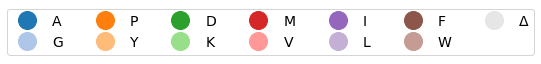

In [17]:
# Set palette and the order of amino acids for meaningful colors
pal = sns.color_palette("tab20")[:13]
pal[12] = (0.9, 0.9, 0.9) # set deletion to gray
sns.set_palette(pal)

fig, ax = plt.subplots(1,1, figsize=(1,1))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pal]
fig.legend(markers, aa_order, numpoints=1, loc='center left', ncol=7, markerscale=3, fontsize=14)
ax.axis('off')
plt.tight_layout()
#plt.savefig('Pie_legend.svg')
plt.show()

In the previous file (filtering positives), I categorised all variants for which we have good evidence into one of five sets: two with high activity, two with low and one intermediate. Here the 

In [18]:
def df_single_enrichment(df, colname = 'variants', restrict = False):
    """
    Input: df listing variants & their seq counts
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    point_distribution = {pos: {aa: 0 for aa in aa_order} for pos in ['6', '7a', '8a', '9', '11', '13']}

    for v_short in df[colname]:
        # m_by_pos[position] = AA
        m_by_pos = convert_variant_to_dict(v_short)

        # in case we are considering relative enrichement, where some position is fixed:
        # the constrains has the form of a dictionary with allowed amino acids in tha tposition
        if not passes_restriction(m_by_pos, restrict):
            continue                

        for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
            point_distribution[pos][aa] += 1
    df_single = pd.DataFrame.from_dict(point_distribution).reindex(aa_order)
    
    return df_single

In [19]:
df_single_enrichment(df.loc[(df['set_numeric'] >=4 )])

,6,7a,8a,9,11,13
A,1960,1575,18059,1796,1389,2541
G,2252,1569,0,1124,1250,1767
P,4037,3437,0,2490,1496,2558
Y,2383,1436,0,1770,1589,1951
D,1065,655,0,1220,1145,1841
K,2725,2500,0,1692,1313,2115
M,3359,1922,0,3673,2815,3439
V,2392,2643,0,2301,2877,3640
I,2744,5354,0,5245,6944,4741
L,5397,7895,0,8096,8392,3920


In [20]:
def five_set_heatmaps(df, ax_lims, log_function, fname='', fsize=(12,3.5)):
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    fig, axes = plt.subplots(1, 6,  figsize=fsize,
                            gridspec_kw={'wspace':0.3, 'hspace':0.3})

    for r in range(6):
        # plot: df/ideal
        if r == 0:
            df_restrict = df_single_enrichment(df)
        else:
            df_restrict = df_single_enrichment(df.loc[(df['set_numeric'] == r)])
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[r], cmap="RdBu_r", cbar=False)
        axes[r].set_title(r)
    
    axes[0].set_title('All')
    
    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()

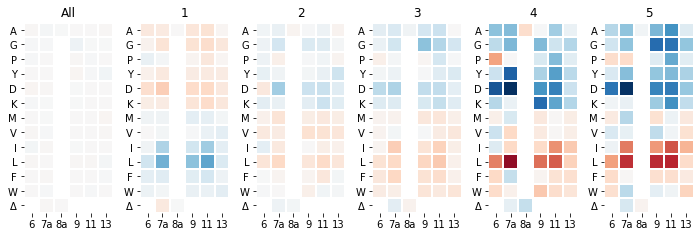

In [21]:
five_set_heatmaps(df, (-2,2), np.log2)

### Heatmap comparison for different cutoffs: active variants 1D & denominator

In [22]:
from ipynb.fs.defs.Library_diversity import convert_variant_to_dict

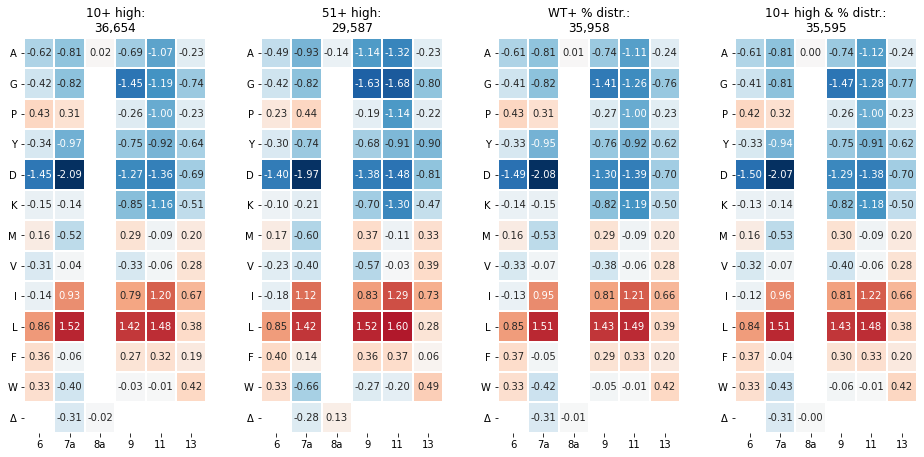

In [96]:
ax_lims = (-2, 2)
cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]



active_choices = {'10+ high': df.loc[(df['high'] >= 10)],
                 '51+ high': df.loc[(df['high'] >= 51)],
                 'WT+ % distr.': df.loc[(df['set_numeric'] >= 4)],
                 '10+ high & % distr.': df.loc[(df['set_numeric'] >= 4) & (df['high'] >= 10)]}

df_all_enrich = df_single_enrichment(df)
bottom_df = df_all_enrich/df_all_enrich.sum()

fig, axes = plt.subplots(1, len(active_choices),  figsize=(16,10), gridspec_kw={'wspace':0.3, 'hspace':0.3})
                  
i = 0
for name, df_plot in active_choices.items():
    df_restrict = df_single_enrichment(df_plot)
    
    # top plot: observed/ideal   
    log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(np.log2)   
    sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[i], cmap="RdBu_r", cbar=False, square=True, annot=True, fmt='.2f',)
    axes[i].set_title(name + ':\n' + '{:,}'.format(len(df_plot)))
    axes[i].tick_params(axis='y', labelrotation = 0)

    
    i+=1
    
plt.show()

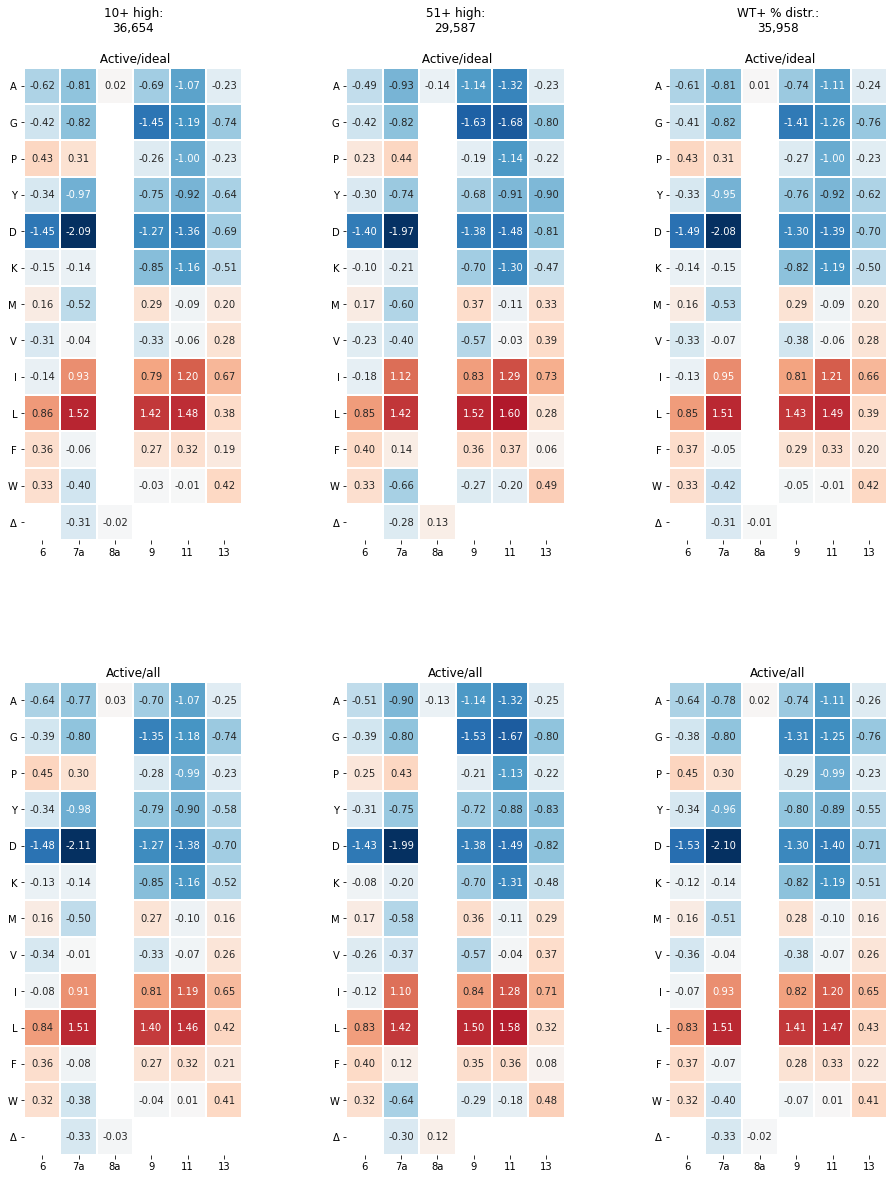

In [94]:
ax_lims = (-2, 2)
cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]



active_choices = {'10+ high': df.loc[(df['high'] >= 10)],
                 '51+ high': df.loc[(df['high'] >= 51)],
                 'WT+ % distr.': df.loc[(df['set_numeric'] >= 4)]}

df_all_enrich = df_single_enrichment(df)
bottom_df = df_all_enrich/df_all_enrich.sum()

fig, axes = plt.subplots(2, len(active_choices),  figsize=(16,20), gridspec_kw={'wspace':0.3, 'hspace':0.3})
                  
i = 0
for name, df_plot in active_choices.items():
    df_restrict = df_single_enrichment(df_plot)
    
    # top plot: observed/ideal   
    log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(np.log2)   
    sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r", cbar=False, square=True, annot=True, fmt='.2f',)
    axes[0][i].set_title(name + ':\n' + '{:,}'.format(len(df_plot)) + '\n\n Active/ideal')
    axes[0][i].tick_params(axis='y', labelrotation = 0)
    
    # bottom plot: observed/all variants
    top_df = df_restrict/df_restrict.sum()

    log_df = (top_df/bottom_df).apply(np.log2)   
    sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r", cbar=False, square=True, annot=True, fmt='.2f',)
    axes[1][i].set_title('Active/all')
    axes[1][i].tick_params(axis='y', labelrotation = 0)
    
    
    i+=1
    
plt.show()

In [24]:
df_active = df.loc[(df['set_numeric'] >= 4)]

In [25]:
bottom_df.to_csv('All_variants_1D.csv')

In [26]:
df_restrict = df_single_enrichment(df_active)
(df_restrict/df_restrict.sum()).to_csv('Active_variants_1D.csv')

In [27]:
df_restrict

,6,7a,8a,9,11,13
A,1960,1575,18059,1796,1389,2541
G,2252,1569,0,1124,1250,1767
P,4037,3437,0,2490,1496,2558
Y,2383,1436,0,1770,1589,1951
D,1065,655,0,1220,1145,1841
K,2725,2500,0,1692,1313,2115
M,3359,1922,0,3673,2815,3439
V,2392,2643,0,2301,2877,3640
I,2744,5354,0,5245,6944,4741
L,5397,7895,0,8096,8392,3920


## 2D joint heatmaps

In [28]:
def two_position_joint_df(df, colname = 'variants'):
    """
    input: df 
    output: nested dictionary containing all joint count dataframes; each dataframe = observed joint frequencies
    """    
    counts = {
        posA : {
            aaA : {
                posB : {
                    aaB: 0 for aaB in splimlib[posB]}
                for posB in valid_pos}
            for aaA in splimlib[posA]}
        for posA in valid_pos}

    for v_short in df[colname]:
        # m_by_pos[position] = AA
        m_by_pos = convert_variant_to_dict(v_short)        
 
        # here this becomes similar as for single enrichments, except we need to loop twice
        for posA, aaA in m_by_pos.items():
            for posB, aaB in m_by_pos.items():
                counts[posA][aaA][posB][aaB] += 1
                
    joint_count_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}

    for posA in valid_pos:
        for posB in valid_pos:
            dict_data = {aaA : [counts[posA][aaA][posB][aaB] for aaB in splimlib[posB]] for aaA in splimlib[posA]}
            joint_count_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=splimlib[posB])

    return joint_count_dfs

In [29]:
joint_count_dfs_active = two_position_joint_df(df_active)
joint_count_dfs_all = two_position_joint_df(df)

The enrichment of variants compared to evenly distributed library: $log(\frac{active_{xy}}{ideal_{xy}})$ or to all detected variants: $log(\frac{active_{xy}}{all_{xy}})$. 1D plot: $log(\frac{freq_{x}}{ideal_{x}})$

In [30]:
len(df_active)

35958

In [76]:
def get_joint_log_dfs(joint_count_dfs_top, log_function, ideal=True, joint_count_dfs_bottom=None):

    log_joint_freq_dfs = {}
    top_joint_freq_dfs = {}
    bottom_joint_freq_dfs = {}

    # make the dataframes
    for posA in valid_pos:
        log_joint_freq_dfs[posA] = {}
        top_joint_freq_dfs[posA] = {}
        bottom_joint_freq_dfs[posA] = {}
        for posB in valid_pos:
            top_df = joint_count_dfs_top[posA][posB]/(joint_count_dfs_top[posA][posB].sum().sum())
            if ideal:
                df_restrict = joint_count_dfs_top[posA][posB]
                bottom_df = df_restrict.mask(df_restrict> 0, 1)/df_restrict.count().sum()
            else:
                bottom_df = joint_count_dfs_bottom[posA][posB]/(joint_count_dfs_bottom[posA][posB].sum().sum())

            log_joint_freq_dfs[posA][posB] = (top_df/bottom_df).apply(log_function)
            top_joint_freq_dfs[posA][posB] = top_df
            bottom_joint_freq_dfs[posA][posB] = bottom_df
            
    return log_joint_freq_dfs, top_joint_freq_dfs, bottom_joint_freq_dfs

In [97]:
df_active = df.loc[(df['high'] >= 51)]
log_jf_dfs, top_jf_dfs, bottom_jf_dfs = get_joint_log_dfs(joint_count_dfs_active, 
                                                                  log_function=np.log2, 
                                                                  ideal=False, 
                                                                  joint_count_dfs_bottom=joint_count_dfs_all)

In [98]:
def labelled_cross_enrichment_plot(ax_lims, log_jf_dfs,fname=None):

    fig, axes = plt.subplots(5, 5, figsize=(13,14),
                             gridspec_kw={'width_ratios': [2,2.2,0.45,2,2],'height_ratios': [2.2,0.4,2,2,2]})
    # figsize (width, height)
    # top left axes = axes[0,0]
    # top row, middle = axes[0,2]
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]

    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            sns.heatmap(log_jf_dfs[valid_pos[a]][valid_pos[b]], vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=ax, 
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'extend': 'both', 'ticks': cbar_ticks},
                        square=True) # all colorbars are plotted to the same axes
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
            ax.tick_params(axis='y', which='major', pad=11)

    # colorbar formatting
    axes[0][2].axis('on')
    
    if fname:
        plt.savefig(fname, transparent=True)
    plt.show()

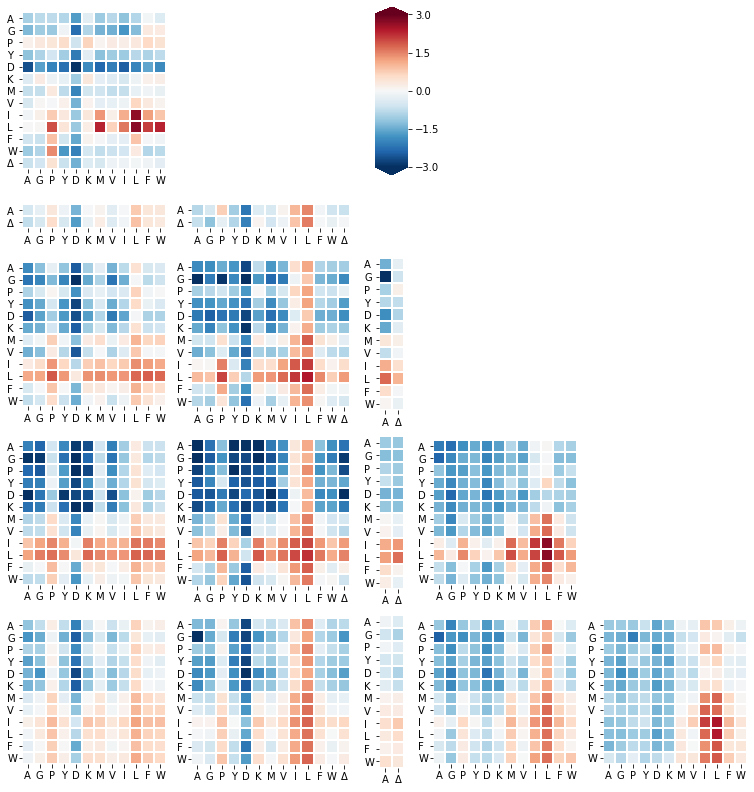

In [100]:
labelled_cross_enrichment_plot((-3,3), log_jf_dfs)

In [91]:
log_jf_dfs, top_jf_dfs, bottom_jf_dfs = get_joint_log_dfs(joint_count_dfs_active, 
                                                                  log_function=np.log2, 
                                                                  ideal=True, 
                                                                  joint_count_dfs_bottom=joint_count_dfs_all)

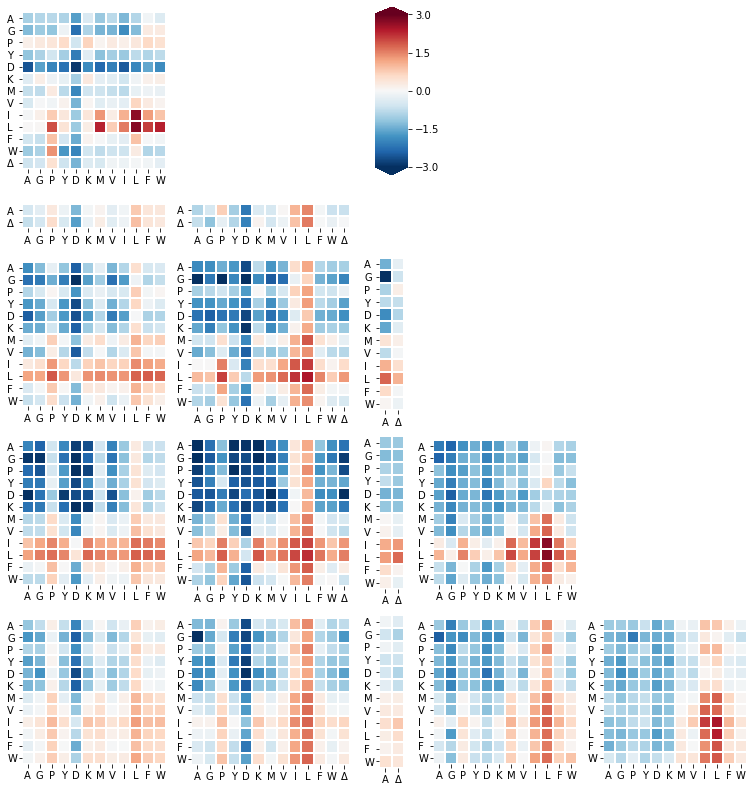

In [92]:
labelled_cross_enrichment_plot((-3,3), log_jf_dfs)

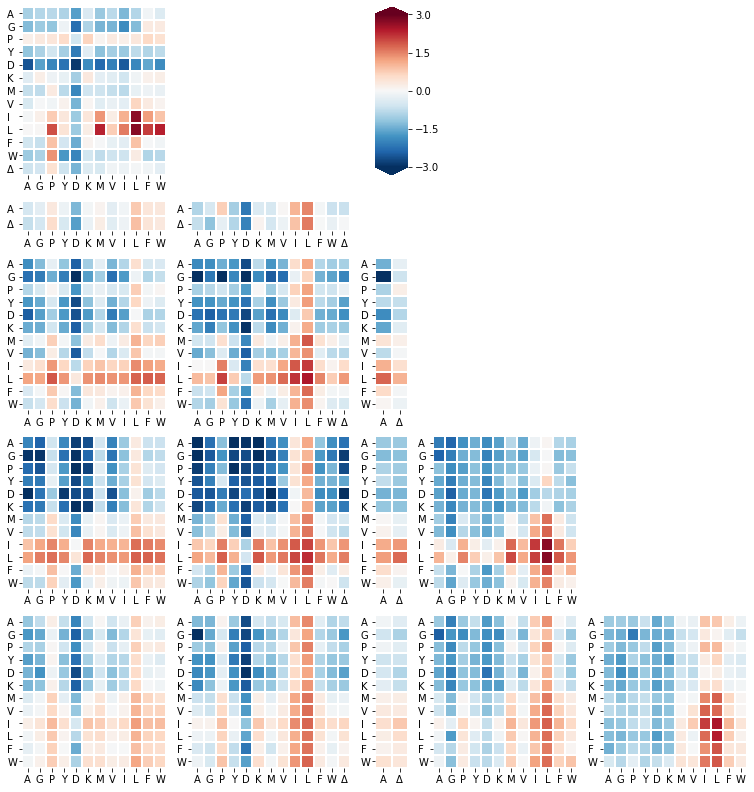

In [31]:
labelled_cross_enrichment_plot((-3,3), np.log2, 'Figure_4_joint_enrichment_labelled.svg')

In [32]:
def cross_enrichment_plot(ax_lims, log_function=np.log10, fname=None):
    
    
    joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, log_function)

    fig, axes = plt.subplots(5, 5, figsize=(13,14),
                             gridspec_kw={'width_ratios': [2,2.2,0.4,2,2],'height_ratios': [2.2,0.4,2,2,2],
                                         'wspace':0.05, 'hspace':0.05})
    # figsize (width, height)
    # top left axes = axes[0,0]
    # top row, middle = axes[0,2]
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]

    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            sns.heatmap(log_freq_dfs[valid_pos[a]][valid_pos[b]], vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=ax, 
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'extend': 'both', 'ticks': cbar_ticks}) # all colorbars are plotted to the same axes
            
            # draw a box, hide labels
            for sp in ax.spines.keys():
                ax.spines[sp].set_visible(True)
            # if we don't want any ticks or labels
            ax.tick_params(bottom=False,left=False, labelbottom=False, labelleft=False)

            # turn the labels back on at the outer edges
            if b == 0:
                ax.tick_params(left=True, labelleft=True)
                ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
                ax.tick_params(axis='y', which='major', pad=11)
            if a == 5:
                ax.tick_params(bottom=True, labelbottom=True)
                ax.set_xlabel(valid_pos[b])
            
    # colorbar formatting
    axes[0][2].axis('on')

#     # add the 1D plot in top right corner
#     ax = axes[0][1]
#     ax.axis('on')
#     log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log10)   
#     sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, cmap="RdBu_r", cbar=False)
#     ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
#     ax.tick_params(axis='y', which='major', pad=11)

    fig.align_labels()

    #plt.tight_layout()
    if fname:
        plt.savefig(fname, transparent=True)
    plt.show()

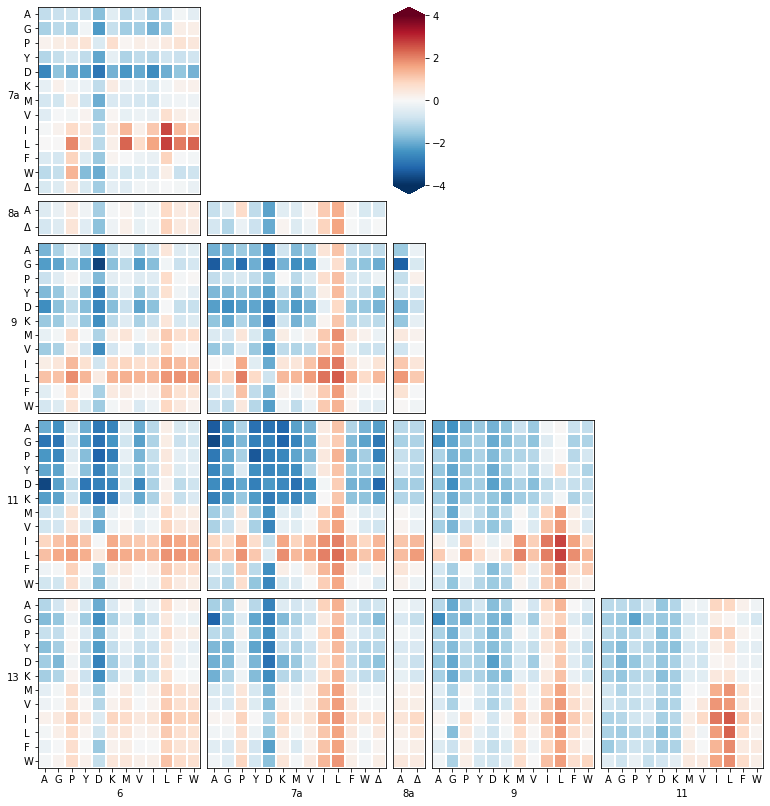

In [33]:
cross_enrichment_plot((-4,4), np.log2, 'Joint_enrichment_log2_-4to4.svg')

#### Conditional probability plots

need to disentangle that normalisation system

In [34]:
log_col_dfs = {}

for posA in valid_pos:
    log_col_dfs[posA] = {}
    for posB in valid_pos:
        top_df = joint_count_dfs[posA][posB] # the joint count of a, b co-occurrence
        bottom_df = joint_count_dfs[posA][posB].sum()/joint_count_dfs[posA][posB].astype(bool).sum(axis=0)
        log_col_dfs[posA][posB] = (top_df/bottom_df).apply(np.log2)

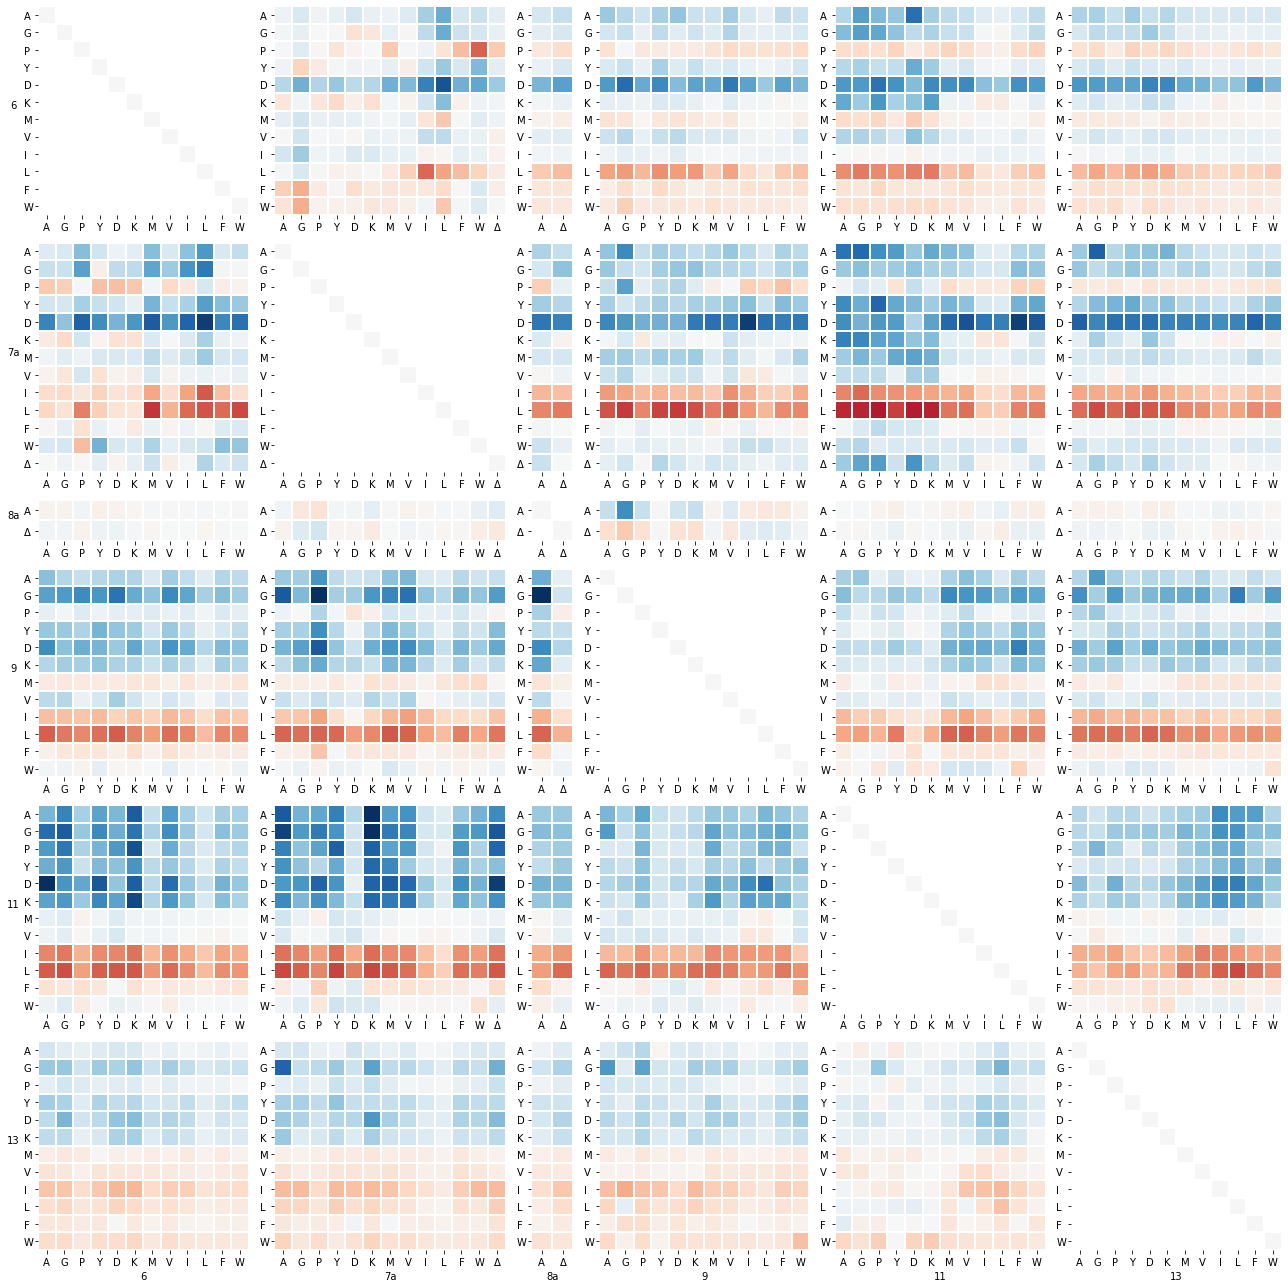

In [35]:
crange=[-3,3]

fig, axes = plt.subplots(6, 6, figsize=(18,18),
                        gridspec_kw={'width_ratios': [2,2.2,0.4,2,2,2],'height_ratios': [2,2.2,0.4,2,2,2]})

# top left axes = axes[0,0]
# top row, middle = axes[0,2]

for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        ax = axes[a][b]
        sns.heatmap(log_col_dfs[valid_pos[a]][valid_pos[b]], vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, 
                    cmap="RdBu_r", cbar=False)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        # set labels on the outer edges
        if b == 0:
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
        if a == 5:
            ax.set_xlabel(valid_pos[b])


plt.tight_layout()
plt.savefig('S14_2D_conditional_heatmap_log2_-3to3.svg')
plt.show()

The conditional dependence of amino acid preference between six randomised positions.

## Epistasis

In [36]:
mi_ideal_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}
df_1D = df_enr/df_enr.sum()

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {}
        for aaA in splimlib[posA]:
            f_a = df_1D[posA][aaA]
            dict_data[aaA] = []
            for aaB in splimlib[posB]:
                f_b =df_1D[posB][aaB]
                try:
                    dict_data[aaA].append(f_a*f_b)
                except ValueError:
                    dict_data[aaA].append(np.nan)
        mi_ideal_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=splimlib[posB])

NameError: name 'df_enr' is not defined

In [ ]:
joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, np.log2)

In [ ]:
def bottom_epistasis_plot(joint_freq_dfs, ax_lims, log_function=np.log10, filt=None, fname=None):

    fig, axes = plt.subplots(5, 5, figsize=(14,13),
                             gridspec_kw={'width_ratios': [2,2.2,0.35,2,2],'height_ratios': [2.2,0.35,2,2,2]})

    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        posA = valid_pos[a]
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            posB = valid_pos[b]
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            df = (joint_freq_dfs[posA][posB]/mi_ideal_dfs[posA][posB]).apply(log_function)

            if filt == 'Positive':
                df[df < 0] = np.nan
            elif filt == 'Negative':
                df[df > 0] = np.nan
                
            # draw heatmap in a box to delineate plots
            sns.heatmap(df, linewidths=0.1, ax=ax, vmin=ax_lims[0], vmax=ax_lims[1], center=0,
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'label': '', 'extend': 'both', 'ticks': cbar_ticks}) # all colorbars are plotted to the same axes

            # set labels on the outer edges
            if b == 0:
                ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
            if a == 5:
                ax.set_xlabel(valid_pos[b])
                
    # colorbar formatting
    axes[0][2].axis('on')

    plt.tight_layout()
    if fname:
        plt.savefig(fname)

    plt.show()

In [ ]:
bottom_epistasis_plot(joint_freq_dfs, (-1, 1), log_function=np.log2, filt='Positive', fname='S13_Epistasis_bottom_log2_-1to1_pos.svg')

In [ ]:
bottom_epistasis_plot(joint_freq_dfs, (-2, 2), log_function=np.log2, filt='Negative', fname='S13_Epistasis_bottom_log2_-2to2_neg.svg')

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

## Chi-squared statistics

In [ ]:
tot = 29563

In [ ]:
expected_df = mi_ideal_dfs['6']['13'].apply(lambda x: x*tot)

In [ ]:
observed_df = joint_count_dfs['6']['13']

In [ ]:
observed_df.sum().sum()

In [ ]:
stats.chisquare(observed_df, expected_df, axis=None)

In [ ]:
pos_order = ['6', '7a', '8a', '9', '11',  '13']
tot = 29563

for i in range(len(pos_order)):
    a = pos_order[i]
    for j in range(i+1, len(pos_order)):
        b = pos_order[j]

        observed_df = joint_count_dfs[a][b]
        expected_df = mi_ideal_dfs[a][b].apply(lambda x: x*tot)
        ch = stats.chisquare(observed_df, expected_df, axis=None)
        print(a, b, ch[1]*15, sep=',')

In [ ]:
ch[1]

## Zoom in on beneficial epistasis

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

## Zooming in on the I/L substitutions and the effect of insertions

In [ ]:
pos_order = ['6', '7a', '8a', '9', '11',  '13']

hydrophobics = {'6': ['P', 'M','L', 'F', 'V'],
                 '7a': ['I', 'L', 'P'],
                  '9': ['I', 'L', 'F', 'M'],
                 '11':['I','L', 'F'],
                 '13': ['M', 'V', 'I', 'F', 'L', 'W']}

i_l = {'6': ['P', 'M','L', 'F', 'V'],
        '7a': ['I', 'L', 'P'],
        '9': ['I', 'L'],
        '11':['I','L'],
        '13': ['I', 'L']}


il_strict = {'6': ['I', 'L'],
        '7a': ['I', 'L'],
        '9': ['I', 'L'],
        '11':['I','L'],
        '13': ['I', 'L']}

In [ ]:
hpho_1 = []
for k1 in pos_order:
    try:
        hpho_1.append({k1 : hydrophobics[k1]})
    except KeyError:
        pass

In [ ]:
il_1 = []
for k1 in pos_order:
    try:
        il_1.append({k1 : il_strict[k1]})
    except KeyError:
        pass

In [ ]:
def find_non_pref_aa(r1):
    r2 = []
    for combo in r1:
        allowed = {}
        for p, good_aa in combo.items():
            bad_aa = [aa for aa in splimlib[p] if not aa in good_aa]
            allowed[p] = bad_aa
        r2.append(allowed)

    return r2

In [ ]:
def restricted_preference_plots(ax_lims, log_function, rest, fname='', fsize=(12,6)):
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    fig, axes = plt.subplots(2, len(rest) +1,  figsize=fsize,
                            gridspec_kw={'wspace':0.3, 'hspace':0.3})
    rest2 = find_non_pref_aa(rest)
    # add the 1D unrestricted plot
    log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(log_function)   
    sns.heatmap(log_enr, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=axes[0][0], cmap="RdBu_r", 
                cbar=False)
    axes[0][0].set_title('All')
    axes[1][0].axis('off')

    for i in range(1,len(rest)+1):
        r = i-1
        
        # top plot: normalise the df relative to even library
        cnts = single_fraction_enrichment(pos, 'high', 1, rest[r], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r", cbar=False)
        t1 = ', '.join(rest[r].keys())
        t2 = 'n = {}'.format(f"{df_restrict.sum()[1]:,}")
        axes[0][i].set_title('{}\n{}'.format(t1, t2))

        # bottom plot: what happens with the inverse sequence restriction
        cnts = single_fraction_enrichment(pos, 'high', 1, rest2[r], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r", cbar=False)
        t2 = 'n = {}'.format(f"{df_restrict.sum()[1]:,}")
        axes[1][i].set_title(t2)
    
    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()

In [ ]:
restricted_preference_plots((-2, 2), np.log2, il_1, fname = 'S15_Phi_log2_-2to2.svg', fsize=(13,7))

In [ ]:
df_restrict.sum()

#### Relative single motif change in distribution

In [ ]:
def restricted_preference_change_plots(ax_lims, log_function, rest, fname='', fsize=(10,6)):

    fig, axes = plt.subplots(2, len(rest),  figsize=fsize)
    rest2 = find_non_pref_aa(rest)
    
    for i in range(len(rest)):
        # top plot: with hydrophobic residues
        cnts = single_fraction_enrichment(pos, 'high', 1, rest[i], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        top_df = df_restrict/df_restrict.sum()
        mask = df_restrict.astype(bool)
        b_df = df_enr.where(mask)/ df_enr.where(mask).sum()
        log_df = (top_df/b_df).apply(np.log2)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r",  cbar=False)
        axes[0][i].set_title(', '.join(rest[i].keys()))

        # bottom  plot: normalise the df relative to df_enr (unrestricted)
        
        cnts = single_fraction_enrichment(pos, 'high', 1, rest2[i], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        top_df = df_restrict/df_restrict.sum()
        mask = df_restrict.astype(bool)
        b_df = df_enr.where(mask)/ df_enr.where(mask).sum()
        log_df = (top_df/b_df).apply(np.log2)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r",  cbar=False)


    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    if fname:
        plt.savefig(fname)
    plt.show()

In [ ]:
restricted_preference_change_plots((-1, 1), np.log2, il_1, 'S15_Phi_log2_relative_-1to1.svg', (9,6))

Moving a single fixed hydrophobic Leu/Ile residue across the D-domain?
- 6: sets a mild preference for a hydrophobic in 7a and a mild relaxation towards the end of D-domain, but the change is very minor.
- 7a: a fairly strong efect that fixes 6Leu/Met, has little effect on 9 (that is, a strong preference of I/L remains, but 11 greatly relaxes towards non-hydrophobics.
- 9: few changes to overall sequence preference, keeping a preference for hydrophobics in 7a and 11. However, without Leu/Ile at 9, the preferences look mostly unchanged, because other hydrophobic residues can take their place in the middle of the motif.
- 11: 9 keeps the usual preference of Leu/Ile, 13 is shifted towards hydrophobics, while 6 and 7a relax. If there is no Leu/Ile here, then the D-domain hydrophobic sequence shifts towards 6 and 7a.
- 13: some strengthening of preference for 11, 9 remains.

Taken together, this suggests the presence of a core hydrophobic motif in three consecutive randomised positions: 6/7a/9, 7a/9/11 or 9/11/13.

### Consecutive two-residue motifs

In [ ]:
aa_pairs = [['6', '7a'], ['7a', '9'], ['9', '11'], ['11', '13']]

il_2 = [{k: il_strict[k] for k in p} for p in aa_pairs]

In [ ]:
restricted_preference_plots((-2, 2), np.log2, il_2, 'S16_PhiXPhi_log2_-2to2.svg', (10,7))

In [ ]:
restricted_preference_change_plots((-1, 1), np.log2, il_2,'S16_PhiXPhi_log2_relative_-1to1.svg', (6.8,6))

### Non-consecutive two-residue motifs: ΦXXXΦ

In [ ]:
nc_aa_pairs = [['6', '9'], ['7a', '11'], ['9', '13']]

il_3 = [{k: il_strict[k] for k in p} for p in nc_aa_pairs]

In [ ]:
restricted_preference_plots((-2, 2), np.log2, il_3, 'S17_PhiXXXPhi_log2_-2to2.svg', fsize=(8.5,7))

In [ ]:
restricted_preference_change_plots((-1, 1), np.log2, il_3,'S17_PhiXXXPhi_log2_relative_-1to1.svg', fsize=(5,6))

## Generate FASTA files for weblogos in different scenarios

In [ ]:
from ipynb.fs.defs.Library_diversity import passes_restriction

In [ ]:
il_3 = [ {'7a': ['I', 'L', 'P'], '9': ['I', 'L']},
 {'9': ['I', 'L'], '11': ['I', 'L']}]

In [ ]:
zero_rest = [{}]

In [ ]:
def generate_weblogo_fasta_from_df(df_pos, rest, names):
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    valid_positions = ['6', '7a', '8a', '9', '11', '13']
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    # make the inverted restrictions
    rest2 = find_non_pref_aa(rest) 
    
    for i in range(len(rest)):
        # different sets of restrictions
        # set up condition name and open the file
        condition_names = ['Hydrophobic_' + names[i] +'.fa', 'Polar_' + names[i]+'.fa']
        
        for c in [0, 1]:
            # 0 = hydrophobic, 1 = inverse
            with open(condition_names[c], 'w') as f:     
                lines = []
                # the variants are the df_pos index
                for v in df_pos.index:
                    m_by_pos = convert_variant_to_dict(v)
                    # check that this variant fits the restriction
                    # the constrains has the form of a dictionary with allowed amino acids in that position
                    if c == 0:
                        if not passes_restriction(m_by_pos, rest[i]):
                            continue
                    else:
                        if not passes_restriction(m_by_pos, rest2[i]):
                            continue  

                    # mask the deletions in the sequence so that weblogo doesn't crash
                    var_list = []
                    for p in valid_positions:
                        aa = m_by_pos[p]
                        if aa == 'Δ':
                            var_list.append('S')
                        else:
                            var_list.append(aa)
                    assert len(var_list) == 6
                    lines.append('>' + str(v) + '\n')
                    lines.append(''.join(var_list) + '\n')
                f.writelines(lines)

In [ ]:
generate_weblogo_fasta_from_df(df_pos, il_3, ['7a-9', '9-11'])

In [ ]:
generate_weblogo_fasta_from_df(df_pos, zero_rest, ['All'])

In [ ]:
subgraph_dict = {i: [H.vs[nd]['id'] for nd in range(len(H.vs)) if H.vs[nd]['leiden'] == i] for i in range(11)}

In [ ]:
def single_fraction_enrichment(mek, fraction, cutoff, restrict = False, proportion=True):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    point_distribution = {pos: {aa: 0 for aa in valid_aa} for pos in ['6', '7a', '8a', '9', '11', '13']}
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

    # the input data is formatted as mek['fraction'][mutation_string] = integer
    # each mutation is a collection of mutations of the format Integer + single letterAA code, separated by '/'
    # we are querying this by position, so need to split by position and convert into a new Counter:
    # mek['fraction']['position']['amino_acid'] = integer
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            # check the mutations is one we're interested in
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
            
            # in case we are considering relative enrichement, where some position is fixed:
            # the constrains has the form of a dictionary with allowed amino acids in tha tposition
            if not passes_restriction(m_by_pos, restrict):
                continue                

            # for the valid AAs, add counts to position proportions
            if proportion:
                for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
                    point_distribution[pos][aa] += count
            else:
                for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
                    point_distribution[pos][aa] += 1
    return point_distribution